In [13]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

############
# parameters
############

N_arr = np.arange(2, 20, 2)
nmax = 20
ω = 1.0
ω0 = 1.0
g = 1.0
tlist = np.arange(0.01, (2*np.pi), 0.1)

######################
# collective operators
######################

def collective_ops(N):
    sp, sm, I = qt.sigmap(), qt.sigmam(), qt.qeye(2)
    Sp = qt.jmat(N/2,'+')
    Sm = Sp.dag()
    Sz = qt.jmat(N/2,'z')
    HB = Sz+N/2*qt.qeye(N+1)
    return Sp, Sm, HB

############################
# Tavis-Cummings Hamiltonian
############################

def tavis_cummings(N, nmax, ω, ω0, g):
    a = qt.destroy(nmax)
    Sp, Sm, HB = collective_ops(N)
    IB = qt.qeye(N+1)
    H = (ω * qt.tensor(a.dag()*a, IB) + ω0 * qt.tensor(qt.qeye(nmax), HB) + g * (qt.tensor(a, Sp) + qt.tensor(a.dag(), Sm)))

    return H, HB

################
# Passive state
################

def passive_state(rho, H):
    r_val, r_vec = rho.eigenstates()
    idx = np.argsort(r_val)[::-1]          # decending order
    r_val = r_val[idx]

    e_val, e_vec = H.eigenstates()          # ascending order

    return sum(r_val[i] * e_vec[i] * e_vec[i].dag()
               for i in range(len(r_val)))

    
########################
# ergotropy calculation
########################

def ergotropy(ρ, H):
    ρ_p = passive_state(ρ, H)
    return qt.expect(H, ρ) - qt.expect(H, ρ_p)


################
# Initial state
################

def initial_state(N, nmax, state):
    if state=="coherent":
        psiA = qt.coherent(nmax, np.sqrt(N))
    elif state=="fock":
        psiA = qt.basis(nmax, N)
    psiB = qt.basis(N+1, 0)  
    return qt.tensor(psiA, psiB)


##############
# Pnm matrix
##############

def pnm_matrix(rho, H):
    r_val, r_vec = rho.eigenstates()
    idx = np.argsort(r_val)[::-1]
    r_val = r_val[idx]
    r_vec = [r_vec[i] for i in idx]

    e_val, e_vec = H.eigenstates()

    dim = len(e_val)
    pnm = np.zeros((dim, dim))

    for m in range(dim):
        for n in range(dim):
            pnm[n, m] = abs(e_vec[n].overlap(r_vec[m]))**2

    return pnm, r_val, e_val
    

############################
# ergotropy using pnm matrix
############################

def ergotropy_pnm(pnm, r_val, e_val):
    deltaE = e_val[:,None] - e_val[None,:]
    return np.sum(r_val[None,:] * pnm * deltaE)


############################
# variance using pnm matrix
############################

def variance_pnm(pnm, r_val, e_val):
    deltaE2 = (e_val[:,None] - e_val[None,:])**2
    mean2 = np.sum(r_val[None,:] * pnm * deltaE2)
    mean = ergotropy_pnm(pnm, r_val, e_val)
    return mean2 - mean**2


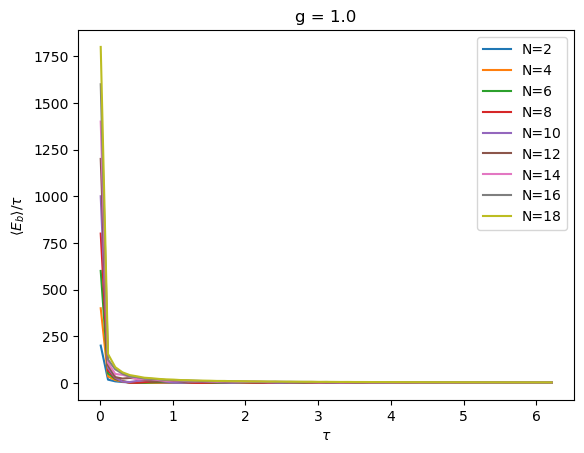

In [14]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

N_arr = np.arange(2, 20, 2)
nmax = 20
ω = 1.0
ω0 = 1.0
g = 1.0

tlist = np.arange(0.01, (2*np.pi), 0.1)

##############################################
# Plot Battery energy <Eb> as function of time 
# and pick time τ for which <Eb> is maximum
##############################################
τ_list = []

for N in N_arr:

    # Build Hamiltonian and battery operator for this N
    H, HB = tavis_cummings(N, nmax, ω, ω0, g)

    # Lift HB to full Hilbert space
    HB_full = qt.tensor(qt.qeye(nmax), HB)

    # Initial state
    ψ0 = initial_state(N, nmax, "fock")

    # Time evolution
    result = qt.sesolve(H, ψ0, tlist, e_ops=HB_full)

    # Battery energy vs time
    Eb_list = np.array(result.expect[0])

    # Maximize charging power Eb / t
    power = Eb_list / tlist
    idx = np.argmax(power)
    τ = tlist[idx]
    τ_list.append(τ)

    # Plot
    plt.plot(tlist, power, label=f"N={N}")

plt.xlabel(r"$\tau$")
plt.ylabel(r"$\langle E_b \rangle / \tau$")
plt.legend()
plt.title(f"g = {g}")
plt.show()


N= 2, τ=0.010, Ergotropy=1.998800, Variance=2.399360e-03
N= 4, τ=0.010, Ergotropy=3.996000, Variance=7.997866e-03
N= 6, τ=0.010, Ergotropy=5.991601, Variance=1.679552e-02
N= 8, τ=0.010, Ergotropy=7.985601, Variance=2.879231e-02
N=10, τ=0.010, Ergotropy=9.978001, Variance=4.398823e-02
N=12, τ=0.010, Ergotropy=11.968802, Variance=6.238327e-02
N=14, τ=0.010, Ergotropy=13.958003, Variance=8.397743e-02
N=16, τ=0.010, Ergotropy=15.945604, Variance=1.087703e-01
N=18, τ=0.010, Ergotropy=17.932376, Variance=1.306749e-01


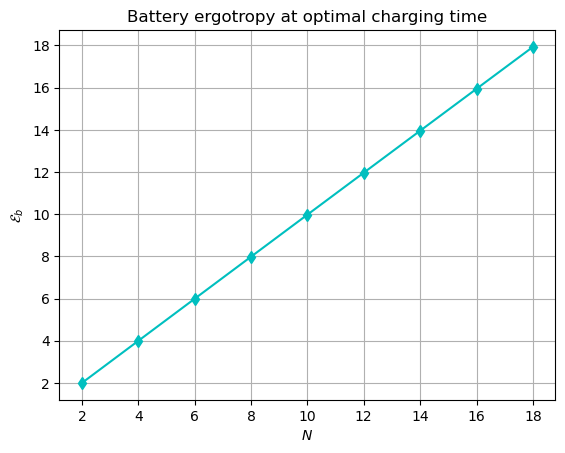

In [15]:
erg_list = []
var_list = []

for i, N in enumerate(N_arr):

    τ = τ_list[i]

    # Rebuild Hamiltonian
    H, HB = tavis_cummings(N, nmax, ω, ω0, g)

    # Initial state
    ψ0 = initial_state(N, nmax, "fock")

    # Evolve until τ
    result = qt.sesolve(H, ψ0, [0, τ])

    # Full density matrix at τ
    ρ_full = result.states[-1].proj()

    # Partial trace over cavity (subsystem 0)
    ρb = ρ_full.ptrace(1)

    # --- Ergotropy via pnm ---
    pnm, r_val, e_val = pnm_matrix(ρb, HB)

    erg = ergotropy_pnm(pnm, r_val, e_val)
    var = variance_pnm(pnm, r_val, e_val)

    print(f"N={N:2d}, τ={τ:.3f}, Ergotropy={erg:.6f}, Variance={var:.6e}")

    erg_list.append(erg)
    var_list.append(var)


############################################
# Plot erg as function of g for different N 
############################################

plt.figure()
plt.plot(N_arr, erg_list, 'd-', color='c')
plt.xlabel(r"$N$")
plt.ylabel(r"$\mathcal{E}_b$")
plt.title("Battery ergotropy at optimal charging time")
plt.grid()
plt.show()


N= 2, τ=0.010, Erg / <EB>=0.999700
N= 4, τ=0.010, Erg / <EB>=0.999500
N= 6, τ=0.010, Erg / <EB>=0.999300
N= 8, τ=0.010, Erg / <EB>=0.999099
N=10, τ=0.010, Erg / <EB>=0.998899
N=12, τ=0.010, Erg / <EB>=0.998698
N=14, τ=0.010, Erg / <EB>=0.998498
N=16, τ=0.010, Erg / <EB>=0.998297
N=18, τ=0.010, Erg / <EB>=0.998118


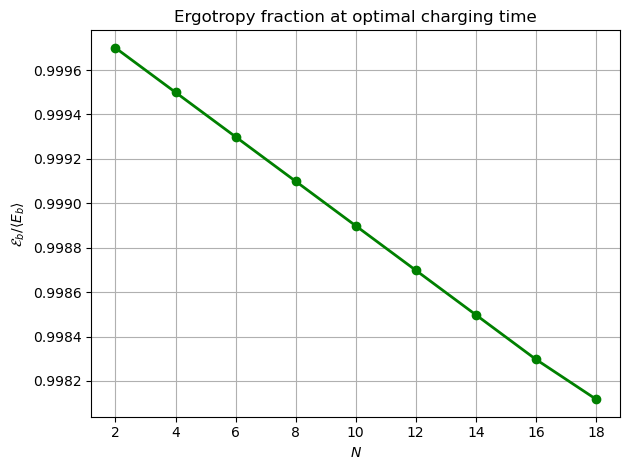

In [16]:
erg_list = []
Eb_list  = []

for i, N in enumerate(N_arr):

    H, HB = tavis_cummings(N, nmax, ω, ω0, g)
    HB_full = qt.tensor(qt.qeye(nmax), HB)

    psi0 = initial_state(N, nmax, "fock")

    # evolve until optimal τ
    result = qt.sesolve(H, psi0, [0, τ_list[i]])
    rho = result.states[-1]

    # reduced battery state
    rho_b = rho.ptrace(1)

    # battery energy
    Eb = qt.expect(HB, rho_b)
    
    # ergotropy (via passive state)
    erg = ergotropy(rho_b, HB)

    Eb_list.append(Eb)
    erg_list.append(erg)

Eb_arr  = np.array(Eb_list)
erg_arr = np.array(erg_list)

ratio = erg_arr / (Eb_arr + 1e-20)   # avoid division by zero

for idx, N in enumerate(N_arr):
    print(f"N={N:2d}, τ={τ_list[idx]:.3f}, Erg / <EB>={ratio[idx]:.6f}")

plt.figure()
plt.plot(N_arr, ratio, 'o-', color='g', linewidth=2)
plt.xlabel(r"$N$")
plt.ylabel(r"$\mathcal{E}_b / \langle E_b \rangle$")
plt.title("Ergotropy fraction at optimal charging time")
plt.grid(True)
plt.tight_layout()
plt.show()


N= 2, τ=0.010, Relative Fluctuation =0.024506
N= 4, τ=0.010, Relative Fluctuation =0.022380
N= 6, τ=0.010, Relative Fluctuation =0.021630
N= 8, τ=0.010, Relative Fluctuation =0.021249
N=10, τ=0.010, Relative Fluctuation =0.021020
N=12, τ=0.010, Relative Fluctuation =0.020868
N=14, τ=0.010, Relative Fluctuation =0.020761
N=16, τ=0.010, Relative Fluctuation =0.020683
N=18, τ=0.010, Relative Fluctuation =0.020159


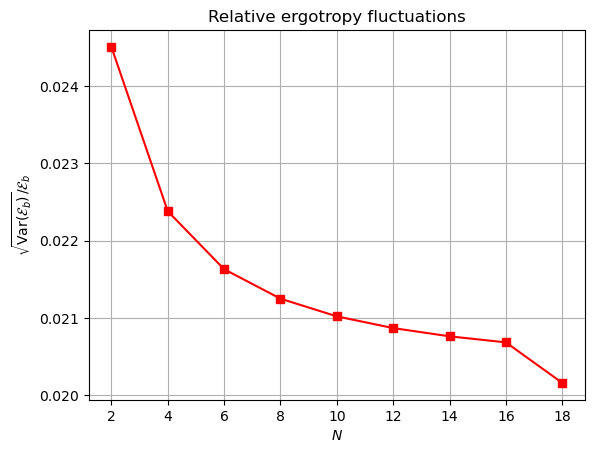

In [17]:
erg_arr = np.array(erg_list)
var_arr = np.array(var_list)

#################################################
# Plot variance as function of g for different N 
#################################################

rel_fluct = np.sqrt(np.array(var_list)) / np.array(erg_list)

for idx, N in enumerate(N_arr):
    print(f"N={N:2d}, τ={τ_list[idx]:.3f}, Relative Fluctuation ={rel_fluct[idx]:.6f}")

plt.figure()
plt.plot(N_arr, rel_fluct, 's-', color='r')
plt.xlabel(r"$N$")
plt.ylabel(r"$\sqrt{\mathrm{Var}(\mathcal{E}_b)}/\mathcal{E}_b$")
plt.title("Relative ergotropy fluctuations")
plt.grid()
plt.show()